# Time-Series Analysis on tips of NYC

This project is used to perform time-series analysis to forecast the tips over time.
This is a followed-up project in TipMax, where we have historical taxi data from 2009 Jan.- 2015 June, c.f. https://github.com/HsiangHung/TIPMAX.
Using the ARIMA models, we will attempt to forecast how much tips we shoud pay (or the NYC taxi drivers should gain)?
Here we use the Python "statsmodels" library, refer http://statsmodels.sourceforge.net/devel/tsa.html#.
Note since the most recent data we have is only 2015 June, the predicted results is based on a fact that "this year is 2015". But if we have more recent data (say to 2016 May), we can have better prediction up to nowadays.


## Loading the data

From the data, we can target the time (say now it is 5PM, 6/1, Wednesday) and find the mean tips by collecting previous 200 Wednesday 5PM with one hour interval data (i.e. 4PM-5PM). The tip ratio may depend on the time, like rush hours? midnight? or early morning? Therefore we need to target the time.

In [102]:
# http://statsmodels.sourceforge.net/devel/tsa.html# time-series statistics tool in Python
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab
from pylab import *

%matplotlib inline

DF = pd.read_csv('history.csv')
DF.head()

,Date,tips
0,2015-06-01,0.152680
1,2015-05-25,0.155415
2,2015-05-18,0.152499
3,2015-05-11,0.152413
4,2015-05-04,0.153144


In [103]:
DF.tail()

,Date,tips
245,2010-09-19,0.148359
246,2010-09-12,0.149223
247,2010-09-05,0.148857
248,2010-08-29,0.153326
249,2010-08-22,0.149030


In [104]:
DF.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
            ...
            240, 241, 242, 243, 244, 245, 246, 247, 248, 249],
           dtype='int64', length=250)

In [105]:
DF.describe()

,tips
count,250.000000
mean,0.153722
std,0.003945
min,0.143740
25%,0.150999
50%,0.153096
75%,0.156239
max,0.176497


In [106]:
DF = DF.iloc[::-1]  ## now the DF has the right time-series order, from early to late
DF.head()

,Date,tips
249,2010-08-22,0.149030
248,2010-08-29,0.153326
247,2010-09-05,0.148857
246,2010-09-12,0.149223
245,2010-09-19,0.148359


In [107]:
import datetime as dtte
start = dtte.datetime.strptime("22 Aug 10", "%d %b %y")
daterange = pd.date_range(start, periods=250,freq='7D')  ## frequency: days
print (type(DF))
df2 = DF['tips']
print (type(df2))
df2.index = pd.Index(daterange)  
## the index daterange is still necessary, otherwise the df2 won't be series format
print(type(df2))
print (df2.tail(10))
df2.head()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
2015-03-29    0.153240
2015-04-05    0.152923
2015-04-12    0.151874
2015-04-19    0.152840
2015-04-26    0.153220
2015-05-03    0.153144
2015-05-10    0.152413
2015-05-17    0.152499
2015-05-24    0.155415
2015-05-31    0.152680
Freq: 7D, Name: tips, dtype: float64


2010-08-22    0.149030
2010-08-29    0.153326
2010-09-05    0.148857
2010-09-12    0.149223
2010-09-19    0.148359
Freq: 7D, Name: tips, dtype: float64

Then we can visualize the relation between tips at different times (from Nov. 2010 to May 2015):

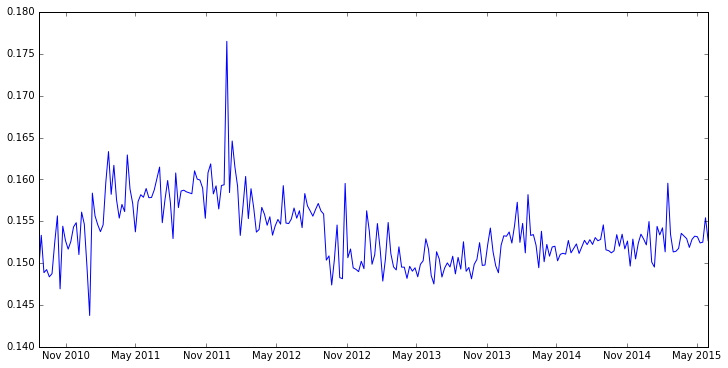

In [108]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(daterange, df2)

## Unit root tests

  The following is to determine if the data is stationary. To implement the ARIMA model to perform time-series analysis, the data needs to be stationary (no obvious trendence and period). If it is non-stationary, then we need to difference the data. 

  We use the most popular unit root test, the Augmentd Dickey-Fuller (ADF) test. The python library can be found in http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html. The null-hypothesis for an ADF test is that the data is non-stationarty. So a large p-value is indicative of non-stationarity, whereas a small p-value suggests stationarity. We use 5% as the threshold. We use our data to do statistic test:

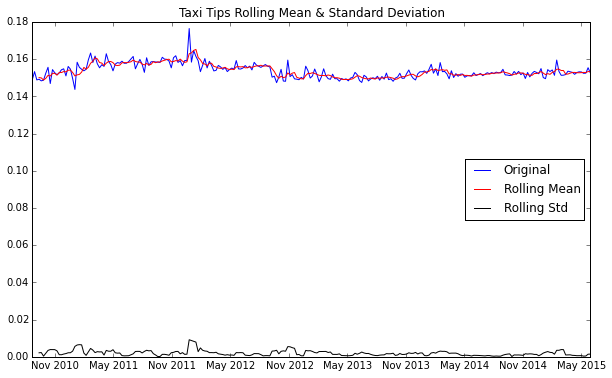

Results of Dickey-Fuller Test:
Test Statistic                  -2.776949
p-value                          0.061643
#Lags Used                       3.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (10%)            -2.573070
Critical Value (5%)             -2.873362
dtype: float64


In [109]:
from statsmodels.tsa.stattools import adfuller
## "adfuller" is for testing stationarity, if reject the hypothesis

def test_stationarity(timeseries):
    ## note here timeseries needs to be class 'pandas.core.series.Series'
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=4)
    rolstd  = pd.rolling_std(timeseries, window=4)
    
    ## rolling_mean = moving ave, window=12 means every 12 months a avg,
    ## so rolmean is "rolmean[0:12]=0, rolmean[12]=np.mean(timeseries[0:12])"
    ## rolmean[13]=np.mean(timeseries[1:13])"
    
    fig = plt.subplots(figsize=(10,6))
    
    original = plt.plot(daterange, timeseries, color='blue',label='Original')
    mean =     plt.plot(daterange, rolmean, color='red', label='Rolling Mean')
    std =      plt.plot(daterange, rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Taxi Tips Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # -------------------------------------------------------------
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') ## for testing stationarity, if yes, reject the hypothesis
    #
    # the null hypothesis is "data are non-stationary", 
    # if P-value > critical value, we cannot reject the null hypothesis
    # if P-value < critical value, we can reject the hypothesis => stationary 
    # if t-stat is comparable to 10% ceritical value, you cannot reject, if t-test small you can reject
    # note negative counts, the ideal case of the value is minus infinity
    # http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
#Apply test to our time series:
test_stationarity(df2) 

So we can observe the p-value is 0.06 > 0.05, meaning that we cannnot reject the null hypothesis. So the data is non-stationary. We need to do some transformation, like take log function and differencing the data to make the data stationary.

## Transformation to make data stationary:

### Log data:

First step we can try to log data:

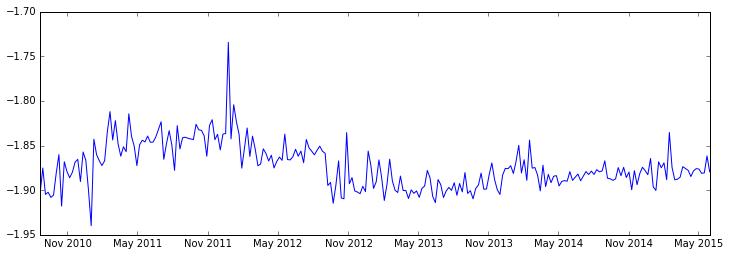

In [110]:
ts_log = np.log(df2)
fig = plt.subplots(figsize=(12,4))
plt.plot(daterange,ts_log)

Now after logging the data, we further take moving mean with 4 weeks as the window.

2010-08-22   -1.903607
2010-08-29   -1.875186
2010-09-05   -1.904767
2010-09-12   -1.902312
2010-09-19   -1.908117
Freq: 7D, Name: tips, dtype: float64 <class 'pandas.core.series.Series'>
2010-08-22         NaN
2010-08-29         NaN
2010-09-05         NaN
2010-09-12   -1.896468
2010-09-19   -1.897595
Freq: 7D, dtype: float64


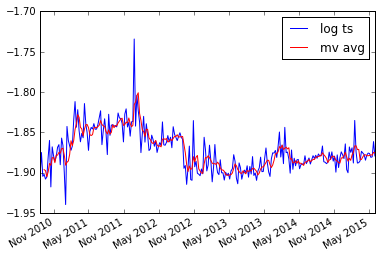

In [111]:
#Now compute the moving average
moving_avg = pd.rolling_mean(ts_log,4)  ## moving mean, window= 4, every 4 weeks do averge.
print (ts_log.head(), type(ts_log))
print (moving_avg.head())
plt.plot(daterange, ts_log, label='log ts')
moving_avg.plot(color='red',label='mv avg')
plt.legend(loc='best')

Next we do first-order differencing the data:

In [112]:
#difference this from the log-ed time series:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head()

2010-08-22         NaN
2010-08-29         NaN
2010-09-05         NaN
2010-09-12   -0.005844
2010-09-19   -0.010522
Freq: 7D, dtype: float64

Now, let us drop off "NAN" in the data to make sure the data is clean, and examine again if the differenced log data is stationary:

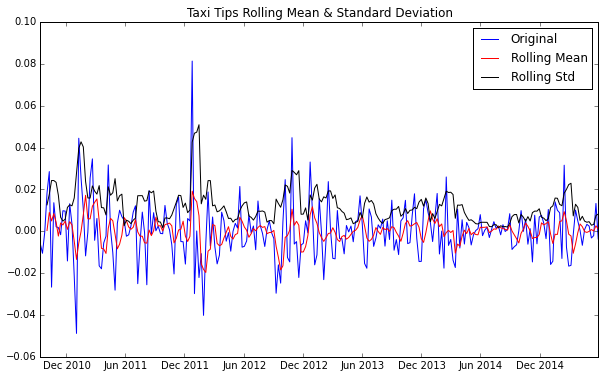

Results of Dickey-Fuller Test:
Test Statistic                -1.338930e+01
p-value                        4.802887e-25
#Lags Used                     2.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (10%)          -2.573122e+00
Critical Value (5%)           -2.873459e+00
dtype: float64


In [113]:
#Drop the NANs and check stationarity:
ts_log_moving_avg_diff.dropna(inplace=True)
daterange = daterange[3:]
test_stationarity(ts_log_moving_avg_diff)

Now afer taking log function on the data and do first-order difference, the data shows stationary in the above. The ADF test shows the p-value is << 0.05, so we can reject the null-hypothesis: the data is non-stationary. We can implement the ARIMA models to the transformed data and make prediction.

### ACF and PACF

There are three main controllable parameters in the ARIMA models, (p,d,q); p: order of autoregression part meaning past values of variable, d: order of difference and q: order of moving average meaning past forecast errors. An (p,d,q) ARIMA model is written as

y(t) = c + phi(1)*y(t-1) +.. +phi(p)*y(t-p) + theta(1)*e(t-1) + .. +theta(q)*e(t-q) + e(t)
          |<-     autoregression        ->|  |<-         moving average                ->|

Here y(t) can be the variable with d-th order difference. If d=1, y(t) = y'(t) = y(t)-y(t-1)

Next we can examine ACF and PACF (parital ACF) to have good initial guess on p and q. The library can be found in http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.acf.html.

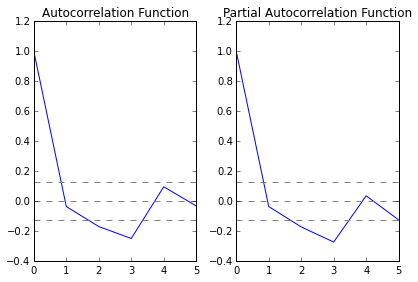

In [114]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_moving_avg_diff, nlags=5)
lag_pacf = pacf(ts_log_moving_avg_diff, nlags=5, method='ols')

#print (lag_acf, lag_pacf)

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')  ##1.96 95% confidence interval
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
## the figures below suggest p=1 from acf, q=1, or 2 from pacf, for (p,d,q) ARIMA models
## for acf, the 0-crossing point is at 1, so p=1; and for pacf q = 1

From the above plots, we see that the ACF has a significant drop at 1, and PACF does it at 1 too. So the good guess of the (p,d,q) ARIMA models (based on our data) is (p=1,q=1). 


### TSA.ARIMA_MODEL fitting

Now if we have (p,d,q), how can we find the coefficients phi and theta? Next we are going to implement the library tsa.arima_model http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.tsa.arima_model.ARIMA.html to fit the equation: 

Phi(L)(yt - Xt*b) = Theta(L)*et, 

where L is the likelihood of the data. It returns the "statsmodels.tsa.arima.ARIMAResults" class and has the fit.aic feature. We also use the Scipy library to brute force (p,d,q) = (0-4,0-4,0-4) in increment of 1. The "fit.aic" gives Akaike's information criterion (AIC):

AIC = -2log(L) + 2(p+q+k+1),

So AIC value is good as lower as possible, meaning maximum likelihood is obtained. Then we can use values of (p,d,q) and (Phi, theta) to build our ARIMA model.

In [115]:
def objfunc(order):    
    from statsmodels.tsa.arima_model import ARMA, ARIMA
    try:
        fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,order).fit()
        #fit = sm.tsa.ARIMA(ts_log,order).fit()
        print(fit.aic)
        print(order)
        return fit.aic
        ## akaike information criterion, how much formation loss for a given model, fit.aic as small as much
        ## nagtive is good, [000] is always a trivial solution
    except:
        print('No good!')
        print(order)

        
from scipy.optimize import brute
import statsmodels.api as sm
grid = (slice(0,4,1), slice(0, 4, 1), slice(0,4,1)) 
### grid=(p,d,q), p,d,q = 0-4
### here is the loop (0,4,1) 0: start, 4: end, 1:increment
brute(objfunc, grid, finish=None) ## scipy function for just doing loop

-1409.74086124
[0 0 0]
-1409.74086124
[0 0 0]
-1408.29035107
[0 0 1]
-1418.42248547
[0 0 2]
-1435.05332232
[0 0 3]
-1223.60484107
[0 1 0]
-1395.58418394
[0 1 1]
-1394.0238101

/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



[0 1 2]
No good!
[0 1 3]
-959.528428329
[0 2 0]
-1210.11423675
[0 2 1]
No good!
[0 2 2]
No good!
[0 2 3]
No good!
[0 3 0]
No good!
[0 3 1]
No good!
[0 3 2]
No good!
[0 3 3]
-1408.08511357
[1 0 0]
-1422.41969573
[1 0 1]
-1424.98891081
[1 0 2]
-1436.39146219
[1 0 3]
-1273.2633952
[1 1 0]
-1393.86336317
[1 1 1]
No good!
[1 1 2]
No good!
[1 1 3]
-1087.43828785
[1 2 0]
No good!
[1 2 1]
No good!
[1 2 2]
No good!
[1 2 3]
No good!
[1 3 0]
No good!
[1 3 1]
No good!
[1 3 2]
No good!
[1 3 3]
-1413.57691803
[2 0 0]
-1426.67199937
[2 0 1]
-1425.15524249

/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



[2 0 2]
-1434.45336163
[2 0 3]
-1289.15462852
[2 1 0]
-1398.78800773
[2 1 1]
No good!
[2 1 2]
No good!
[2 1 3]
-1118.25443789
[2 2 0]
No good!
[2 2 1]
No good!
[2 2 2]
-1374.53373143
[2 2 3]
No good!
[2 3 0]
No good!
[2 3 1]
No good!
[2 3 2]
No good!
[2 3 3]
-1430.71300777
[3 0 0]
-1429.504327

/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



[3 0 1]
No good!
[3 0 2]
-1432.61849815
[3 0 3]
-1341.05698689
[3 1 0]
-1414.58077103

/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



[3 1 1]
-1411.7974504
[3 1 2]
No good!
[3 1 3]
-1190.5211339
[3 2 0]
No good!
[3 2 1]
No good!
[3 2 2]
No good!
[3 2 3]
No good!
[3 3 0]
No good!
[3 3 1]
No good!
[3 3 2]
No good!
[3 3 3]


array([ 0.,  1.,  3.])

The above parameter scan tells us that (p,d,q) = [0,0,3], [1,0,3], [2,0,3] and [3,0,3] provided lower AIC than others.
Next we further check the convergence:

In [66]:
#Double check convergence [0 0 3], [1 0 2], [3 0 1] = (p,d,q)
fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,(0,0,3)).fit()
print(fit.aic)
fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,(1,0,3)).fit()
print(fit.aic)
fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,(2,0,3)).fit()
print(fit.aic)
fit = sm.tsa.ARIMA(ts_log_moving_avg_diff,(3,0,3)).fit()
print(fit.aic)

-1435.053322323009
-1436.3914621859913
-1434.4533616317185

/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



-1432.6184981465835


Unfortunately, from these double check, we can infer the best convergent answers is given by (p,d,q) = [1,0,3]. 
How is our model with the parameter selection? We can visualize the fitting result:

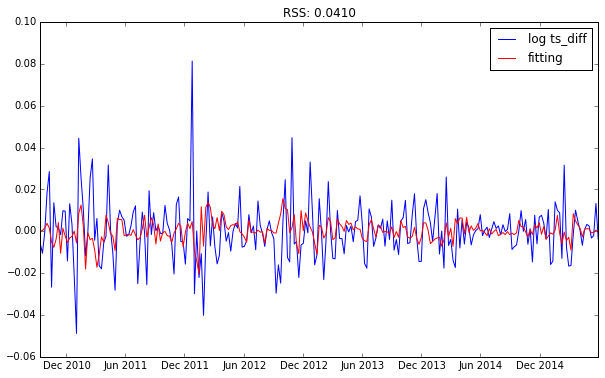

In [67]:
model = sm.tsa.ARIMA(ts_log_moving_avg_diff, order=(1, 0, 3))  
#model = sm.tsa.ARIMA(ts_log, order=(2, 0, 1))
results_ARIMA = model.fit(disp=-1) ## disp plot parameters

fig = plt.subplots(figsize=(10,6))
plt.plot(daterange, ts_log_moving_avg_diff, label='log ts_diff')
plt.plot(daterange, results_ARIMA.fittedvalues, color='red', label='fitting')
ParRSS = results_ARIMA.fittedvalues-ts_log_moving_avg_diff
ParRSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum((ParRSS)**2))
plt.legend(loc='best')

The blue line denotes the differenced log data. The red line is given by the fitting results using the Python library with (p,d,q) = [1,0,3]. We can observe the fitting results significantly catch the data variance later time (from Dec. 2013 to ...).

Then we can use the (1,0,3) ARIMA model to forecast the future:

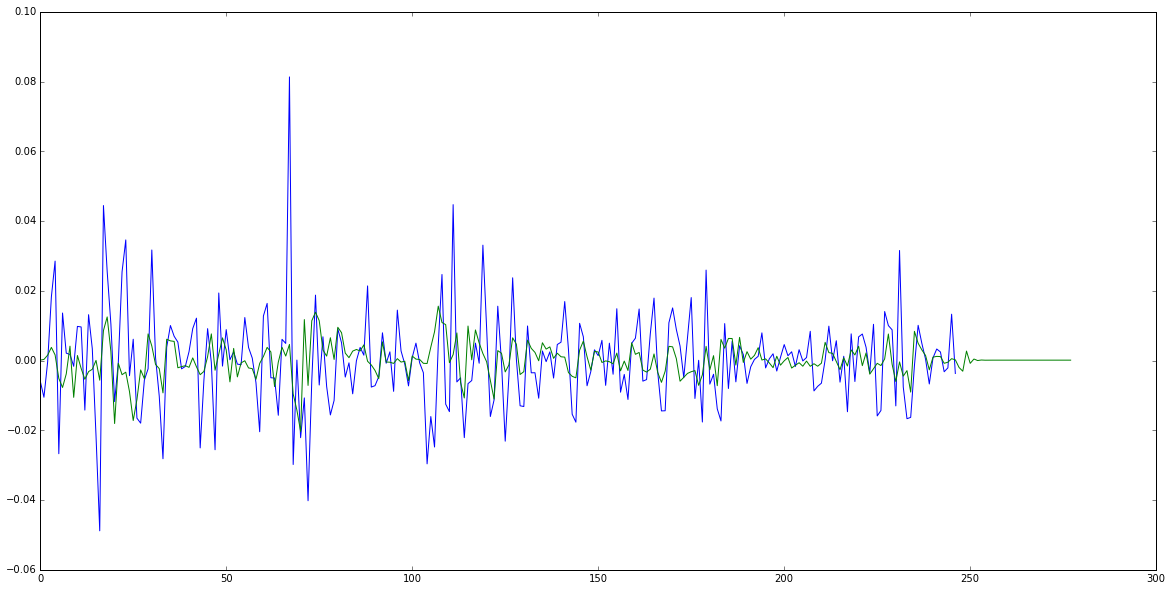

In [89]:
plt.subplots(figsize=(20, 10))
plt.plot(ts_log_moving_avg_diff)
plt.plot(sm.tsa.ARIMA(ts_log_moving_avg_diff, (1,0,3)).fit(disp=-1).predict('2010-09-12', '2015'))

The blue line is the differenced log data. The green line is the (1,0,3) ARIMA model fitting result. However, note that the data shown above is the differenced log data. We still need to transform back to the original data, i.e. removing log and without difference:

2016-04-03    0.153711
2016-04-10    0.153711
2016-04-17    0.153711
2016-04-24    0.153711
2016-05-01    0.153711
2016-05-08    0.153711
2016-05-15    0.153711
2016-05-22    0.153711
2016-05-29    0.153711
2016-06-05    0.153711
dtype: float64


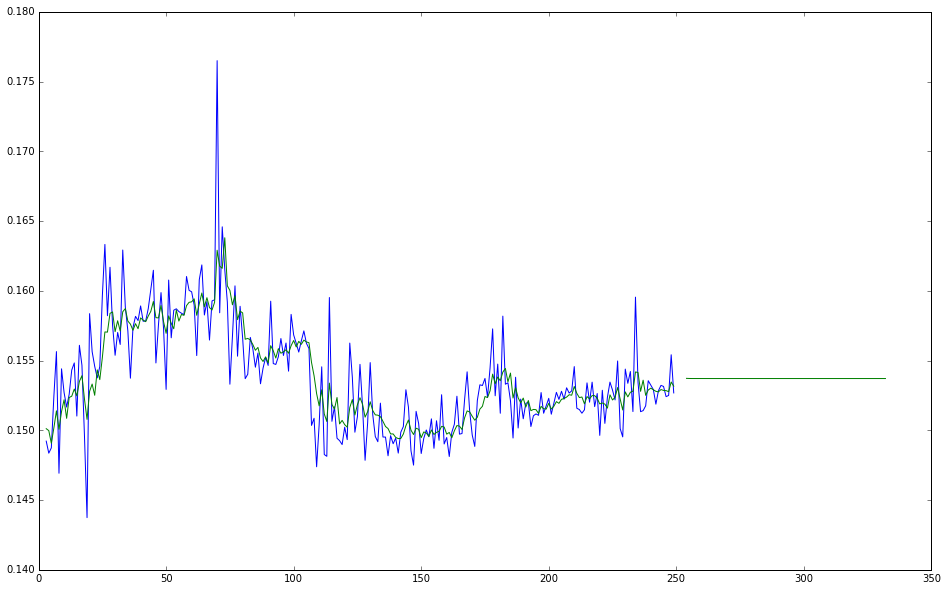

In [119]:
SplitPredict = predictions_ARIMA_diff['2015-06-30':]
InRangePredict = predictions_ARIMA_diff[:'2015-06-30']
InRangeTrans = InRangePredict + moving_avg
MovingToAdd = moving_avg.mean()
AverageDF = pd.Series([MovingToAdd for x in range(len(SplitPredict.index))], index=SplitPredict.index)
PredictedNew = SplitPredict + AverageDF
FullPredict = pd.Series.append(InRangeTrans,PredictedNew)
compare = ts_log_moving_avg_diff + moving_avg
compare = np.exp(compare)
FullPredict = np.exp(FullPredict)
subplots(figsize=(16,10))
plt.plot(compare)
plt.plot(FullPredict)
print (FullPredict[len(FullPredict)-40:len(FullPredict)-30])

Therefore, by the previous history, the best tip to the NYC taxi drivers is about 15.3%. One interesting thing observed here is that there exists an anomaly-like peak in the data, which is around 2011 Christmas holiday. This suggests the drivers if they would like to work during the holiday, they may receive extra bonus.